***Parameter Definitions***

In [8]:
nx, ny, nz              = 32, 32,32                     # Spatial Dimension
m                       = 32                             # Number of Patterns
dd_factor               = 8                              # Detector Downsampling Factor

Loading Data

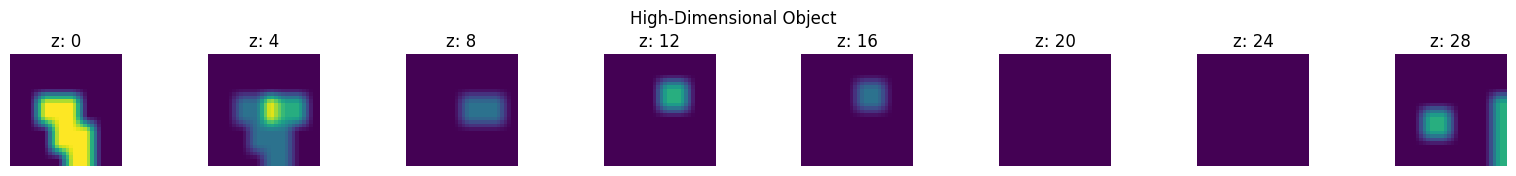

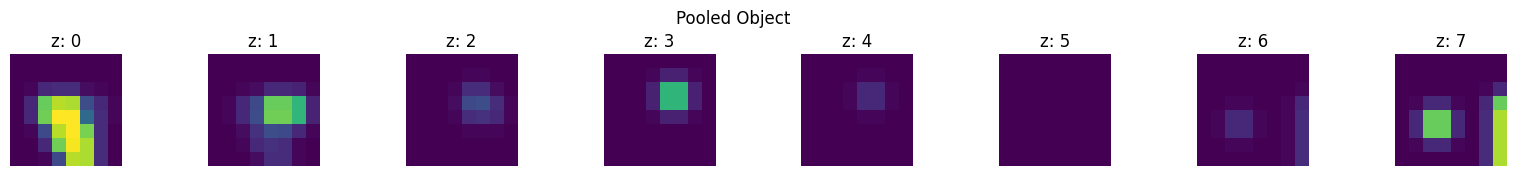

Read Object Parameters
--------------------------
Spatial Dimension	: 32×32×32
Original Dimension	: 8×8×8
Reduced Dimension	: 8×8×8
Raw Data Type		: neural_cell
Device			: cuda



In [25]:
from libs.forward_lib.read_data import ReadData

# Initialize the Read Data Model
RD = ReadData(nx, ny, nz, up_factor=4)

# Loading Cellular Data
RD.load_object("neural_cell")

# Visualizing the original Data
RD.visualize_data(is_orginal=True, n_planes=8)

# Average Pooling Operation To Reduce Dimension
RD.reduce_dimension()

# Visualize the Dimension Reduced Data
RD.visualize_data(n_planes=8)
print(RD)

Linearized Model

In [26]:
from libs.forward_lib.linearized_process import LinearizedModel

# # Initialize the Linear Model
# LM = LinearizedModel(nx,ny,nz, m, dd_factor, init_call=True)

# # Better Understand the Model Parameters
# print(LM)

# # Calculate the Dimension Reduced Matrix
# LM.approximate_A()

# # LM.save_original_matrix()
# # LM.save_original_matrix(original_=False)

#---------LOAD A SAVED MOEDL----------------------------------------#

LM = LinearizedModel()
LM.load_matrix(it = 129, is_original=False)
print(LM)

Linearized Model Specifications
----------------------------------------------
NA 				: 0.8
Space Dimension 		: 10.240um × 10.240um × 10.240um
Analog Voxel Size 		: 0.08um × 0.08um × 0.08um
Reduced Voxel Size 		: 0.32um × 0.32um × 0.32um
Original Shape 			: 128 × 128 × 128
Reduced Shape 			: 32 × 32 × 32
DMD Patterns 			: 32
# of Plane			: 1
Detector Pool size 		: 8×8
Computational Device 		: cuda




### Psedo Inverse Based Solution

In [ ]:
import torch
from libs.forward_lib.visualizer import show_planes
A_PINV = torch.linalg.pinv(LM.A_r)  
x_re = A_PINV@(LM.A_r@RD.X.flatten())
X_re = x_re.view(nz, nx, ny)

RD.visualize_data(is_orginal=True)
show_planes(X_re.detach().cpu().numpy(), title = "Reconstructed Object", N_z = nz)

***Prepare X,A,y for twist***

In [27]:
X = RD.X.flatten().cpu().numpy()
FM = LM.A_r.cpu().numpy()

In [15]:
import numpy as np

def add_gaussian_noise(signal, snr_dB):
    signal_power = np.mean(signal**2)
    snr = 10**(snr_dB/10.0)
    noise_power = signal_power/snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

y_clean = FM@X

desired_snr_dB = 20.0
y_noisy = add_gaussian_noise(y_clean, desired_snr_dB)

Run twist

In [23]:
import libs.reconstruction_lib.TWIST as TWIST
import libs.reconstruction_lib.twist_utils as utils

y = y_clean

# absAty = np.abs(utils.AT(y, FM, nx, ny, nz))
# tau = 1e-7*np.max(absAty) # Regularization parameter
tau = 1e0 # Regularization parameter
Psi = 'TV' # denoising function ('TV', 'SOFT', 'SOFT_DWT')
Phi = 'L1' # regularization function ('TV', 'L1', 'L1_DWT')
lam1 = 1e-4 # twist parameter
stop_criterion = 1 # 0:non-zero components, 1:change in obj func, 2:estimate, 3:value of obj func 
tolA = 1e-3 # Stopping threshold
init = 0 # 0:zero, 1:random, 2:Aty, 3:init_x given by user
init_x = None # initial estimate

x_twist, dummy, obj_twist, times_twist, dummy, mse_twist, dummy = TWIST.TwIST(y, FM, tau, nx, ny, nz,
                                                                                Psi=Psi, Phi=Phi,
                                                                                lam1=1e-4, alpha=0, beta=0,
                                                                                stop_criterion=stop_criterion, tolA=tolA,
                                                                                init=init, init_x=init_x,
                                                                                enforceMonotone=1,
                                                                                true_x=X, compute_mse=1,
                                                                                verbose=1)


Initial objective = 1675329705869312.0, nonzeros = 0
Incrementing S = 2
Incrementing S = 4
Incrementing S = 8
Incrementing S = 16
Incrementing S = 32
Incrementing S = 64
Incrementing S = 128
Incrementing S = 256
Incrementing S = 512
Incrementing S = 1024
Incrementing S = 2048
Incrementing S = 4096
Incrementing S = 8192
Incrementing S = 16384
Incrementing S = 32768
Incrementing S = 65536
Incrementing S = 131072
Incrementing S = 262144
Incrementing S = 524288
Incrementing S = 1048576
Incrementing S = 2097152
Incrementing S = 4194304
Incrementing S = 8388608
Incrementing S = 16777216
Incrementing S = 33554432
Incrementing S = 67108864
Incrementing S = 134217728
Incrementing S = 268435456
Incrementing S = 536870912
Incrementing S = 1073741824
Incrementing S = 2147483648
Incrementing S = 4294967296
Incrementing S = 8589934592
Incrementing S = 17179869184
Incrementing S = 34359738368
Incrementing S = 68719476736
Incrementing S = 137438953472
Incrementing S = 274877906944
Incrementing S = 54

Visualize results

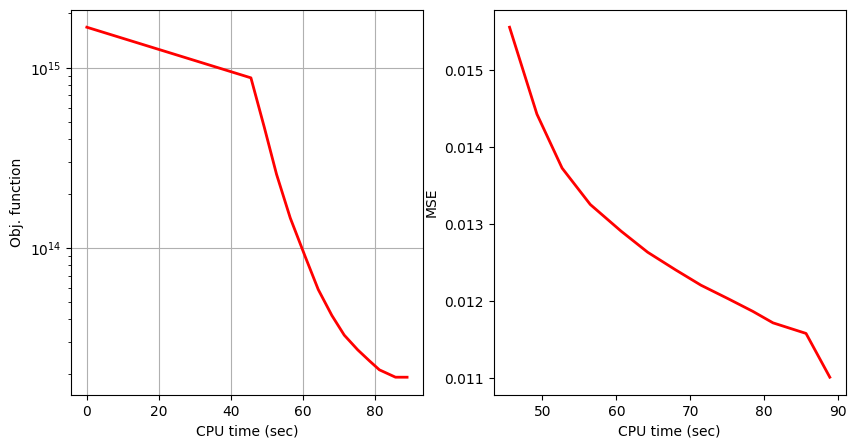

TwIST CPU time: 88.890625
MSE Loss: 1.1015e-02


In [24]:
utils.plot_obj_mse(obj_twist, times_twist, mse_twist, figsize=(10,5))

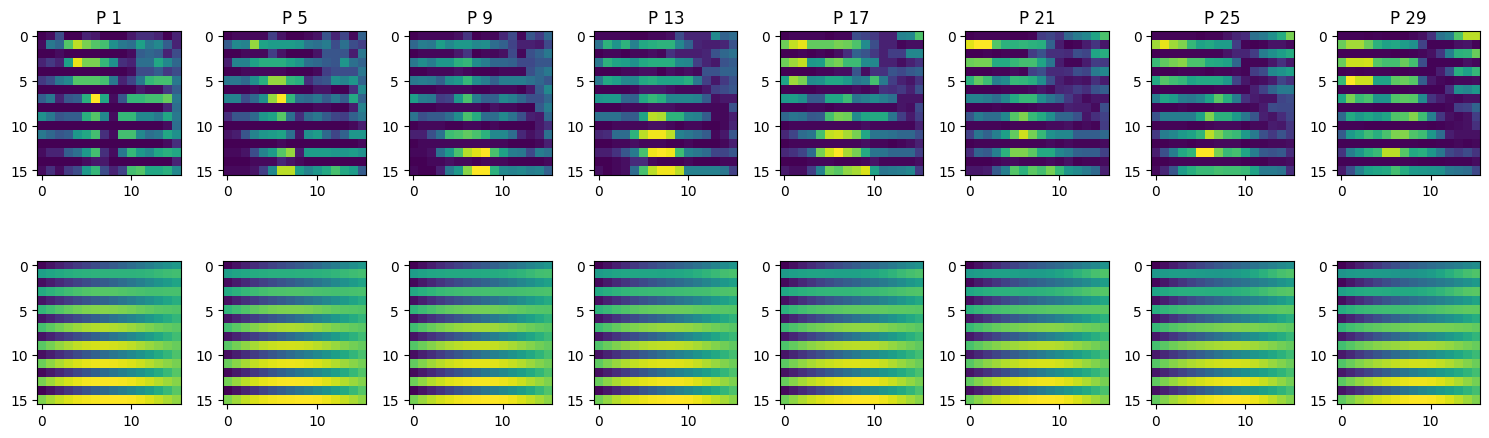

plane 1 | SSIM = 0.4866 | PSNR = 6.1193 dB
plane 2 | SSIM = 0.1159 | PSNR = 5.0178 dB
plane 3 | SSIM = 0.1169 | PSNR = 7.8094 dB
plane 4 | SSIM = -0.0555 | PSNR = 7.7656 dB
plane 5 | SSIM = 0.5596 | PSNR = 7.2259 dB
plane 6 | SSIM = 0.2665 | PSNR = 5.7268 dB
plane 7 | SSIM = 0.2024 | PSNR = 8.1762 dB
plane 8 | SSIM = 0.0212 | PSNR = 7.7807 dB
plane 9 | SSIM = 0.5751 | PSNR = 6.8425 dB
plane 10 | SSIM = 0.2908 | PSNR = 5.9201 dB
plane 11 | SSIM = 0.2148 | PSNR = 8.4936 dB
plane 12 | SSIM = -0.0053 | PSNR = 7.4754 dB
plane 13 | SSIM = 0.4816 | PSNR = 5.2657 dB
plane 14 | SSIM = 0.3303 | PSNR = 4.9708 dB
plane 15 | SSIM = 0.2335 | PSNR = 8.7421 dB
plane 16 | SSIM = 0.0647 | PSNR = 7.9405 dB


In [25]:
ssim_values, psnr_values = utils.comparison2(X, x_twist, nx//2, ny//2, nz//2, figsize=(15, 5), planes_to_plot=range(0,nz,4))